In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\Python\Data Science\Road Damage\pothole_detection_CNN\Datasetv2',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1284 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [5]:
len(dataset)

41

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[2 2 2 0 2 0 2 2 0 0 1 1 1 0 1 2 0 0 0 1 1 1 0 1 2 0 2 1 2 2 0 0]


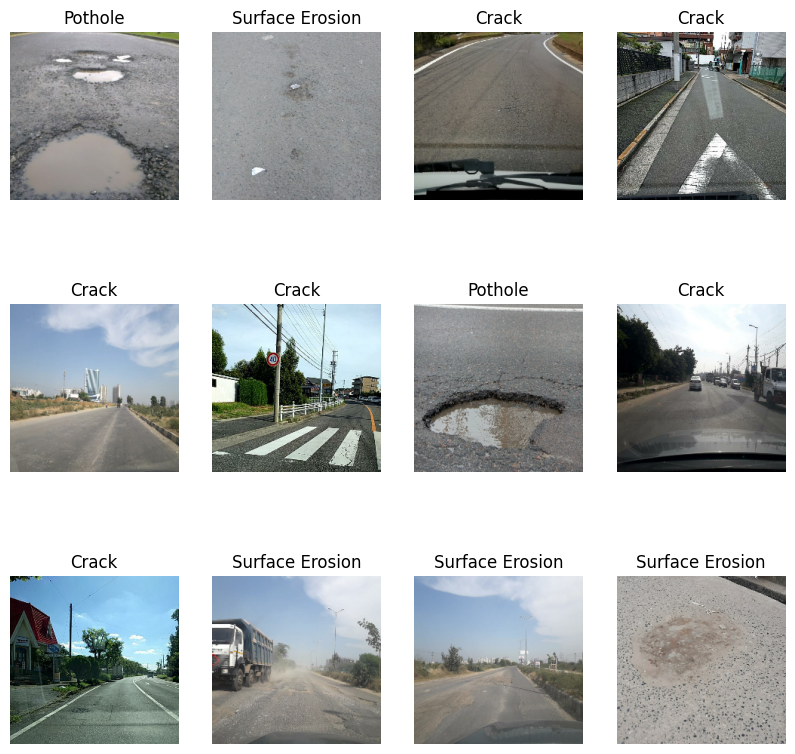

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
total_size = len(dataset)

In [9]:
def partition_data(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds  = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    validation_size = int(val_split * ds_size)
    train_data = ds.take(train_size)
    validation_data = ds.skip(train_size).take(validation_size)
    test_data = ds.skip(train_size).skip(validation_size)
    return train_data, validation_data, test_data
train_data, validation_data, test_data = partition_data(dataset)
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 32
Validation data size: 4
Test data size: 5


In [10]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomContrast(0.2)
])

In [13]:


def build_mobilenet_model():
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model


In [14]:
model = build_mobilenet_model()

In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5978 - loss: 1.1979 - val_accuracy: 0.7422 - val_loss: 0.7291
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8549 - loss: 0.3933 - val_accuracy: 0.8828 - val_loss: 0.3566
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8845 - loss: 0.2923 - val_accuracy: 0.8828 - val_loss: 0.3406
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8848 - loss: 0.3119 - val_accuracy: 0.9062 - val_loss: 0.2566
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8767 - loss: 0.3147 - val_accuracy: 0.9141 - val_loss: 0.2291
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9006 - loss: 0.2570 - val_accuracy: 0.9297 - val_loss: 0.2119
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9003 - loss: 0.2544 - val_accuracy: 0.9297 - val_loss: 0.2037
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9063 - loss: 0.2409 - val_accuracy: 0.9297 - val_loss:

In [18]:
scores = model.evaluate(test_data)
scores

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9760 - loss: 0.0649


[0.06873895227909088, 0.9750000238418579]

In [ ]:
model.save("Trained Modelv2/MOBILENETv1.o.h5")
model.save("Trained Modelv2/MOBILENETv1.o.keras")

NameError: name 'model' is not defined

In [20]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 32}

In [21]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [22]:
history.history['accuracy']

[0.7108433842658997,
 0.8514056205749512,
 0.8654618263244629,
 0.8895582556724548,
 0.8835341334342957,
 0.9116466045379639,
 0.9096385836601257,
 0.9216867685317993,
 0.9206827282905579,
 0.9397590160369873,
 0.9397590160369873,
 0.9287148714065552,
 0.9337349534034729,
 0.9457831382751465,
 0.9437751173973083,
 0.9497991800308228,
 0.9528112411499023,
 0.9548192620277405,
 0.9487951993942261,
 0.9548192620277405,
 0.9598393440246582,
 0.9558233022689819,
 0.9518072009086609,
 0.9668674468994141,
 0.9698795080184937,
 0.9698795080184937,
 0.9678714871406555,
 0.9638554453849792,
 0.9628514051437378,
 0.9759036302566528,
 0.977911651134491,
 0.9618473649024963,
 0.9708835482597351,
 0.9718875288963318,
 0.968875527381897,
 0.9789156913757324,
 0.9748995900154114,
 0.9748995900154114,
 0.9738956093788147,
 0.9769076108932495,
 0.9829317331314087,
 0.9769076108932495,
 0.9819276928901672,
 0.9628514051437378,
 0.9769076108932495,
 0.9799196720123291,
 0.9849397540092468,
 0.977911651134

In [23]:
y_true = []
y_pred = []
for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
F1 Score (macro): 0.9745092838196285
F1 Score (weighted): 0.975

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.98      0.98      0.98        52
        Pothole       0.98      0.98      0.98        58
Surface Erosion       0.96      0.96      0.96        50

       accuracy                           0.97       160
      macro avg       0.97      0.97      0.97       160
   weighted avg       0.97      0.97      0.97       160



In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

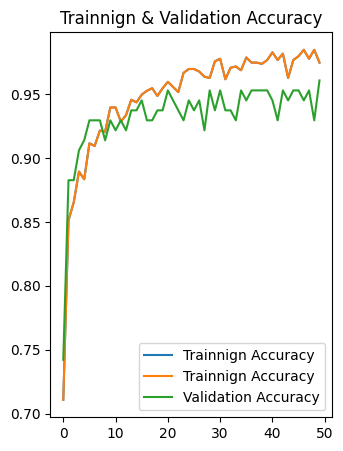

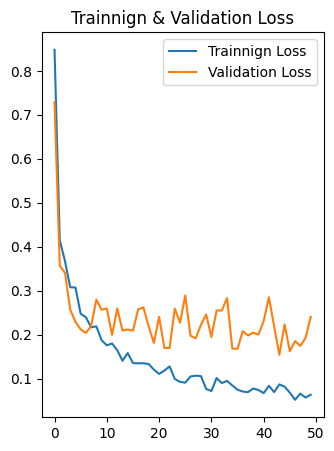

In [34]:

plt.figure(figsize = (8,5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")
plt.show()
plt.figure(figsize = (8,5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [26]:
model.evaluate(test_data)

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9843 - loss: 0.0554


[0.06873895227909088, 0.9750000238418579]

First image to predict
First image actual label:  Surface Erosion
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label:  Surface Erosion


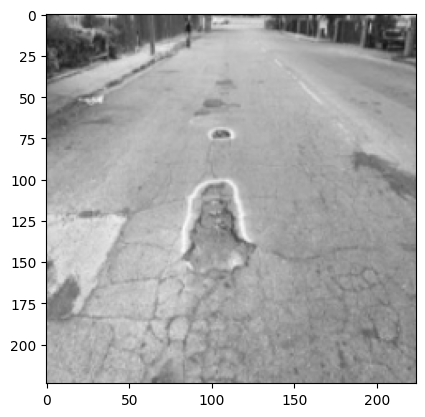

In [27]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()
    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->92.91000366210938 Light:-> Normal lighting
Confidence:->99.08000183105469 Light:-> Normal lighting
Confidence:->84.22000122070312 Light:-> Normal lighting
Confidence:->100.0 Light:-> Low light
Confidence:->99.95999908447266 Light:-> Normal lighting
Confidence:->99.87999725341797 Light:-> Normal lighting
Confidence:->94.55999755859375 Light:-> Normal lighting
Confidence:->100.0 Light:-> Normal lighting
Confidence:->94.87999725341797 Light:-> Normal lighting


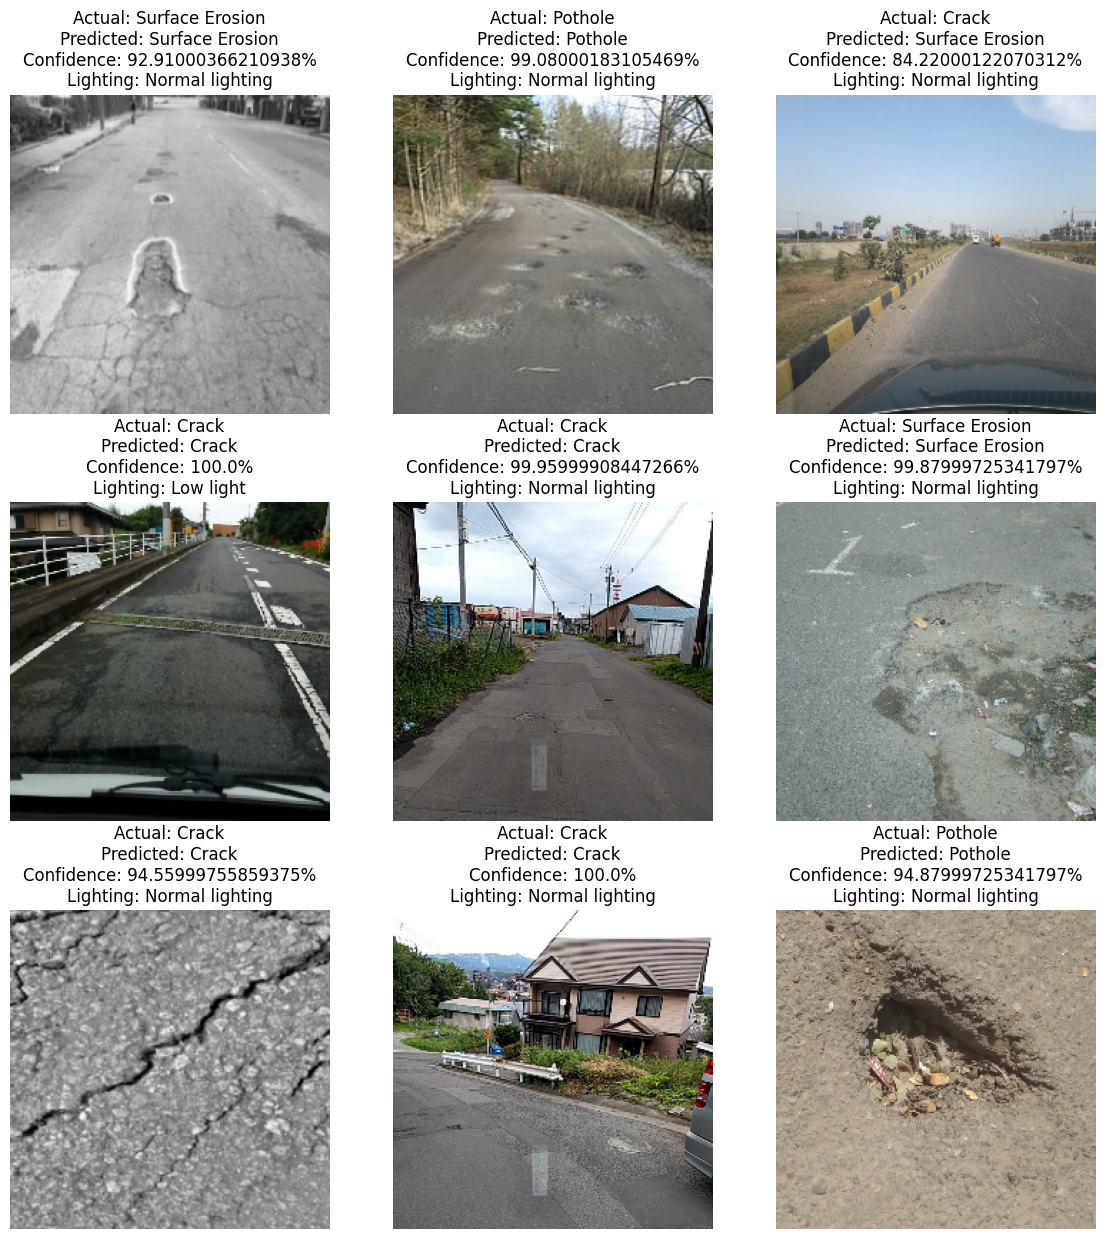

In [29]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [30]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")

Prediction: Pothole, Confidence: 94.87999725341797


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


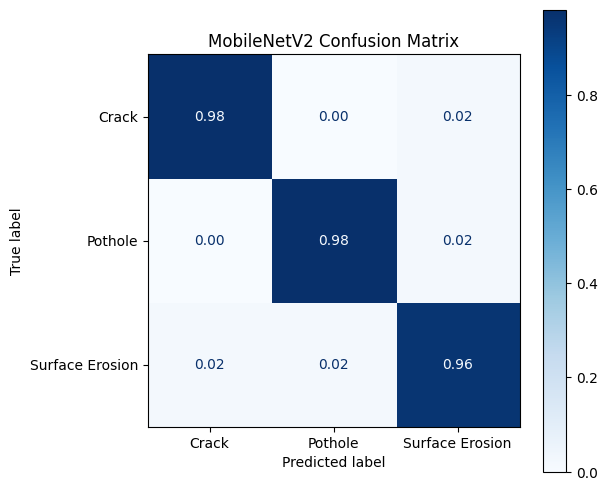

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []
for images, labels in test_data:
    predictions = model.predict(images)
    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("MobileNetV2 Confusion Matrix")
plt.savefig("Confusion Matrx/Mobilenetv1.o.png", dpi=300, bbox_inches='tight')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


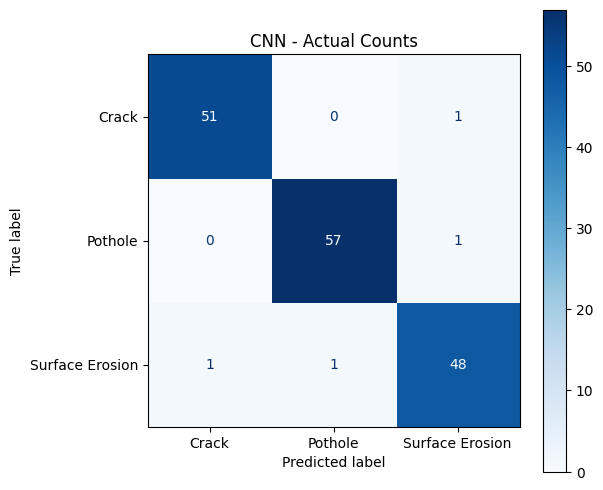

In [37]:
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute raw confusion matrix (actual counts)
cm = confusion_matrix(y_true, y_pred)

# Plot raw confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format="d")  # "d" for integer values
plt.title("CNN - Actual Counts")
plt.savefig("Confusion Matrx/CNNx_counts.png", dpi=300, bbox_inches='tight')
plt.show()